In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import os

In [ ]:
# Define key constants
IMG_SIZE = 224 # ResNet50 was trained on 224x224 images
BATCH_SIZE = 32
# IMPORTANT: Update this path to where your 'train' and 'test' folders are
# For example: '/mnt/c/Users/joaog/Deep_Learning/Dataset/chest_xray'
data_dir = '/mnt/c/Users/joaog/Deep_Learning/Dataset/chest_xray'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'test') # It's good practice to have a validation set

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE)
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    shuffle=False, # No need to shuffle validation data
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE)
)

class_names = train_dataset.class_names
print("Classes found:", class_names)
print(f"You have {len(class_names)} classes.")

# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)


Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Classes found: ['NORMAL', 'PNEUMONIA']
You have 2 classes.


In [1]:
import os
import tensorflow as tf

# Define key constants
IMG_SIZE = 224
BATCH_SIZE = 32
data_dir = '/mnt/c/Users/joaog/Deep_Learning/Dataset/chest_xray'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'test') # It's good practice to have a validation set

# --- Counting images in the training set ---
print("Training set:")
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        print(f"- {class_name}: {num_images} images")

print("\n" + "="*20 + "\n") # Separator

# --- Counting images in the validation set ---
print("Validation set:")
for class_name in os.listdir(val_dir):
    class_dir = os.path.join(val_dir, class_name)
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        print(f"- {class_name}: {num_images} images")

# You can still create your datasets as before
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE)
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE)
)

class_names = train_dataset.class_names
print("\nClasses found:", class_names)
print(f"You have {len(class_names)} classes.")

# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

2025-06-05 23:38:45.746161: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-05 23:38:45.924839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749177525.993505     728 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749177526.013024     728 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749177526.176001     728 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Training set:
- NORMAL: 1341 images
- PNEUMONIA: 3875 images


Validation set:
- NORMAL: 234 images
- PNEUMONIA: 390 images
Found 5216 files belonging to 2 classes.


I0000 00:00:1749177548.750902     728 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 624 files belonging to 2 classes.

Classes found: ['NORMAL', 'PNEUMONIA']
You have 2 classes.


In [23]:
print("The 'cardinality' method returned -2 (UNKNOWN).")
print("Using the guaranteed .reduce() method instead...")

# Define the starting count as a TensorFlow constant
initial_count = tf.constant(0, dtype=tf.int64)

# Use reduce to iterate and count each element
# This will take a few seconds as it actually goes through the dataset
image_count_train = train_dataset.unbatch().reduce(initial_count, lambda x, _: x + 1)

# The result is a Tensor, so we use .numpy() to see the number
print(f"\nSUCCESS: The object 'train_dataset' contains exactly: {image_count_train.numpy()} images.")

image_count_val = validation_dataset.unbatch().reduce(initial_count, lambda x, _: x + 1)
print(f"\nSUCCESS: The object 'val_dataset' contains exactly: {image_count_val.numpy()} images.")

The 'cardinality' method returned -2 (UNKNOWN).
Using the guaranteed .reduce() method instead...

SUCCESS: The object 'train_dataset' contains exactly: 5216 images.

SUCCESS: The object 'val_dataset' contains exactly: 624 images.


In [24]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# ResNet50 requires a specific preprocessing step
# This function will be applied to the input images
preprocess_input = tf.keras.applications.resnet50.preprocess_input

# Load the ResNet50 model
# include_top=False means we DON'T want the final 1000-class classification layer
# weights='imagenet' specifies to use the weights learned from the ImageNet dataset
base_model = tf.keras.applications.ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# FREEZE the base model. The learned weights will not be updated during training.
base_model.trainable = False
print("\nBase model is now FROZEN.")
# base_model.summary() # Optional: see the architecture

# Build our new model on top of the base model
# We define the flow of data using the Keras Functional API
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)        # First, apply data augmentation
x = preprocess_input(x)              # Then, apply ResNet50 preprocessing
x = base_model(x, training=False)    # Then, run it through the frozen base model
                                     # `training=False` is important here!
x = layers.GlobalAveragePooling2D()(x) # Pool the features to a single vector
x = layers.Dropout(0.2)(x)             # Add dropout for regularization

# Finally, add our own classification layer.
# Since we have 2 classes, we use a single Dense neuron with a sigmoid activation.
outputs = layers.Dense(1, activation='sigmoid')(x)

# Create the final model
model = tf.keras.Model(inputs, outputs)


Base model is now FROZEN.


In [25]:
# --- 3. COMPILE AND TRAIN THE HEAD ---

# We compile the model with a standard Adam optimizer and binary crossentropy loss
# since it's a two-class problem.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n--- Training the custom head ---")
# Train the model, only updating the weights of the new layers
initial_epochs = 10
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset
)



--- Training the custom head ---
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 155ms/step - accuracy: 0.8262 - loss: 0.3658 - val_accuracy: 0.7548 - val_loss: 0.6211
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 149ms/step - accuracy: 0.9519 - loss: 0.1378 - val_accuracy: 0.7676 - val_loss: 0.6124
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.9571 - loss: 0.1167 - val_accuracy: 0.8045 - val_loss: 0.4959
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.9535 - loss: 0.1136 - val_accuracy: 0.7676 - val_loss: 0.6813
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.9625 - loss: 0.1057 - val_accuracy: 0.8285 - val_loss: 0.4688
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - accuracy: 0.9571 - loss: 0.1016 - val_accuracy: 0.7837 - val_loss: 0.6549
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 154ms/step - accuracy: 0.9643 - loss: 0.1004 - val_accuracy: 0.8253 - val_loss: 0.4707
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 154ms

In [15]:
# --- 4. FINE-TUNING ---

# Now, we will "unfreeze" the top layers of the base model and train the whole
# model with a very low learning rate.

print("\n--- Starting Fine-Tuning ---")
base_model.trainable = True

# Let's unfreeze from the 140th layer onwards. The early layers learn
# very generic features (edges, colors), so we keep them frozen.
fine_tune_at = 140
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile the model with a much lower learning rate.
# This is CRITICAL for successful fine-tuning.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # 0.00001
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Continue training the model
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Start from where we left off
    validation_data=validation_dataset
)



--- Starting Fine-Tuning ---
Epoch 10/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 188ms/step - accuracy: 0.9543 - loss: 0.1111 - val_accuracy: 0.6875 - val_loss: 0.4587
Epoch 11/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 185ms/step - accuracy: 0.9696 - loss: 0.0790 - val_accuracy: 0.6875 - val_loss: 0.5254
Epoch 12/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 186ms/step - accuracy: 0.9799 - loss: 0.0609 - val_accuracy: 0.8125 - val_loss: 0.2803
Epoch 13/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 162ms/step - accuracy: 0.9796 - loss: 0.0557 - val_accuracy: 0.8750 - val_loss: 0.2028
Epoch 14/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 164ms/step - accuracy: 0.9789 - loss: 0.0531 - val_accuracy: 0.8750 - val_loss: 0.2403
Epoch 15/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 184ms/step - accuracy: 0.9827 - loss: 0.0455 - val_accuracy: 0.9375 - val_loss: 0.1151
Epoch 16/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 177ms/step - accuracy: 0.9831 - loss: 0.0422 - val_accuracy: 1.0000 - val_loss: 0.0923
Epoch 17/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 1

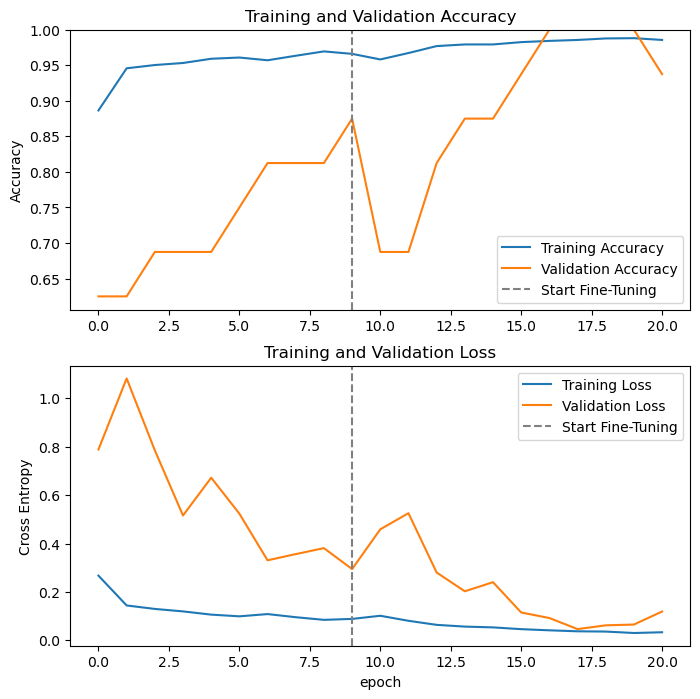


Model training complete.


In [16]:
# Let's plot the learning curves
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# Add a line to show where fine-tuning started
plt.axvline(initial_epochs -1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(initial_epochs - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.show()

print("\nModel training complete.")